In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the range for x and y coordinates
x = np.linspace(0, 10, 10, dtype=np.float16)
y = np.linspace(0, 9, 10, dtype=np.int64)

# Create a grid of coordinates
X, Y = np.meshgrid(x, y, indexing="xy")
x_coords = X.flatten()
y_coords = Y.flatten()

print(x)

[ 0.     1.111  2.223  3.334  4.445  5.555  6.668  7.777  8.89  10.   ]


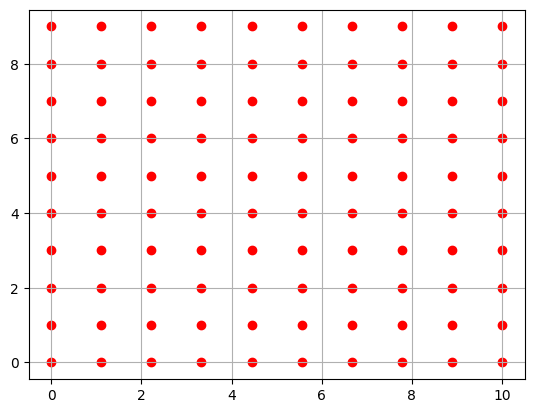

In [3]:
plt.scatter(x_coords, y_coords, c="r", marker="o")
plt.grid(True)
plt.show()

In [4]:
from scipy.spatial import distance_matrix

coords = np.column_stack((x_coords, y_coords))
distance_matrix(coords, coords)

array([[ 0.        ,  1.11132812,  2.22265625, ..., 11.894834  ,
        12.65081866, 13.45362405],
       [ 1.11132812,  0.        ,  1.11132812, ..., 11.19981091,
        11.89611112, 12.64944614],
       [ 2.22265625,  1.11132812,  0.        , ..., 10.5761313 ,
        11.2009735 , 11.894834  ],
       ...,
       [11.894834  , 11.19981091, 10.5761313 , ...,  0.        ,
         1.11328125,  2.22265625],
       [12.65081866, 11.89611112, 11.2009735 , ...,  1.11328125,
         0.        ,  1.109375  ],
       [13.45362405, 12.64944614, 11.894834  , ...,  2.22265625,
         1.109375  ,  0.        ]])

In [1]:
from scenarios import ScenarioZero

scenario = ScenarioZero(
    num_of_zones_per_row=10, zone_length=10, lambda_param=0.5, planning_horizon=0.3
)

region = scenario.service_region

print(region.stops_coords[0])

plt.scatter(region.stops_coords[0], region.stops_coords[1], c="r", marker="o")
plt.grid(True)
plt.show()

print(region.stops_distance_matrix)

[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.  5. 15. 25. 35. 45. 55. 65. 75.
 85. 95.  5. 15. 25. 35. 45. 55. 65. 75. 85. 95.  5. 15. 25. 35. 45. 55.
 65. 75. 85. 95.  5. 15. 25. 35. 45. 55. 65. 75. 85. 95.  5. 15. 25. 35.
 45. 55. 65. 75. 85. 95.  5. 15. 25. 35. 45. 55. 65. 75. 85. 95.  5. 15.
 25. 35. 45. 55. 65. 75. 85. 95.  5. 15. 25. 35. 45. 55. 65. 75. 85. 95.
  5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]


NameError: name 'plt' is not defined